# Used Cars Prices Prediction Model

## Import Data

In [1]:
from google.colab import files

uploaded = files.upload()

Saving train.csv to train (1).csv


In [2]:
%pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.1 MB/s eta 0:00:00


## Data Loading

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import joblib

# Load the CSV file
file_path = 'train.csv'
data = pd.read_csv(file_path)
data.head()
data.describe(include='all')

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
count,6019,6019,6019.000000,6.019000e+03,6019,6019,6019,6017,5983,5983,5977.000000,824,6019.000000
unique,1876,11,NaN,NaN,5,2,4,442,146,372,NaN,540,NaN
top,Mahindra XUV500 W8 2WD,Mumbai,NaN,NaN,Diesel,Manual,First,18.9 kmpl,1197 CC,74 bhp,NaN,95.13 Lakh,NaN
freq,49,790,NaN,NaN,3205,4299,4929,172,606,235,NaN,6,NaN
mean,NaN,NaN,2013.358199,5.873838e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.278735,NaN,9.479468
std,NaN,NaN,3.269742,9.126884e+04,NaN,NaN,NaN,NaN,NaN,NaN,0.808840,NaN,11.187917
min,NaN,NaN,1998.000000,1.710000e+02,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.440000
25%,NaN,NaN,2011.000000,3.400000e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,3.500000
50%,NaN,NaN,2014.000000,5.300000e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,5.640000
75%,NaN,NaN,2016.000000,7.300000e+04,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,9.950000


## Data Cleaning

In [4]:
# General information about the dataset
data.info()
print(data.isnull().sum())

# Filling null values
data['Mileage'] = data['Mileage'].fillna(data['Mileage'].mode()[0])
data['Engine'] = data['Engine'].fillna(data['Engine'].mode()[0])
data['Power'] = data['Power'].fillna(data['Power'].mode()[0])
data['Seats'] = data['Seats'].fillna(data['Seats'].median())

# Dropping 'New_Price' column due to many null values
data = data.drop(columns=['New_Price'])

# Convert 'Mileage', 'Engine', and 'Power' to numeric after removing units
data['Mileage'] = data['Mileage'].str.extract('(\d+\.\d+)')[0].astype(float)
data['Engine'] = data['Engine'].str.extract('(\d+)')[0].astype(float)
data['Power'] = data['Power'].str.extract('(\d+\.\d+|\d+)')[0].astype(float)

# Check for any remaining non-numeric columns
print(data.dtypes)

# Converting categorical variables to dummy variables
data = pd.get_dummies(data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

# Verify cleaned data
data.info()
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_

## Exploratory Data Analysis

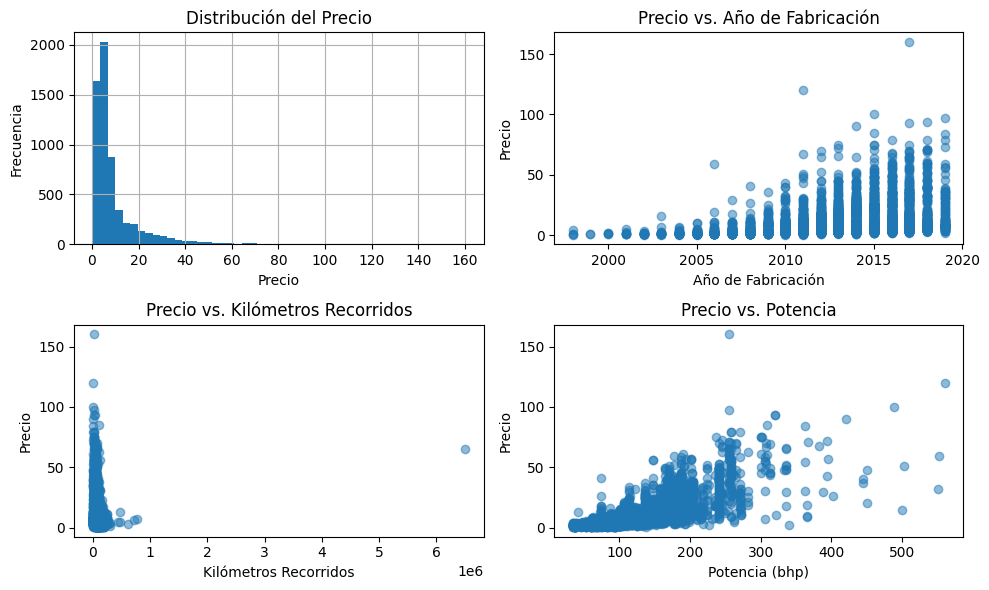

In [5]:
# Configure figure size
plt.figure(figsize=(10, 6))

# Price distribution
plt.subplot(2, 2, 1)
data['Price'].hist(bins=50)
plt.title('Distribución del Precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Price vs. Year
plt.subplot(2, 2, 2)
plt.scatter(data['Year'], data['Price'], alpha=0.5)
plt.title('Precio vs. Año de Fabricación')
plt.xlabel('Año de Fabricación')
plt.ylabel('Precio')

# Price vs. Kilometers Driven
plt.subplot(2, 2, 3)
plt.scatter(data['Kilometers_Driven'], data['Price'], alpha=0.5)
plt.title('Precio vs. Kilómetros Recorridos')
plt.xlabel('Kilómetros Recorridos')
plt.ylabel('Precio')

# Price vs. Power
plt.subplot(2, 2, 4)
plt.scatter(data['Power'], data['Price'], alpha=0.5)
plt.title('Precio vs. Potencia')
plt.xlabel('Potencia (bhp)')
plt.ylabel('Precio')

# Show plots
plt.tight_layout()
plt.show()

## Data Splitting

In [6]:
# Select features and target variable
X = data.drop(columns=['Name', 'Location', 'Price'])
y = data['Price']

# Ensure no NaN values in X
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training and Evaluation

In [7]:
# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")


MAE: 4.016023428427128
MSE: 64.97709361399106
RMSE: 8.060837029365565
R2: 0.47198633267260837


## Feature Importance Analysis

**Purpose:** To identify which features (variables) have the most influence on predicting car prices.

**Benefit:** Helps in understanding the dataset better and can improve model performance by focusing on the most relevant features.

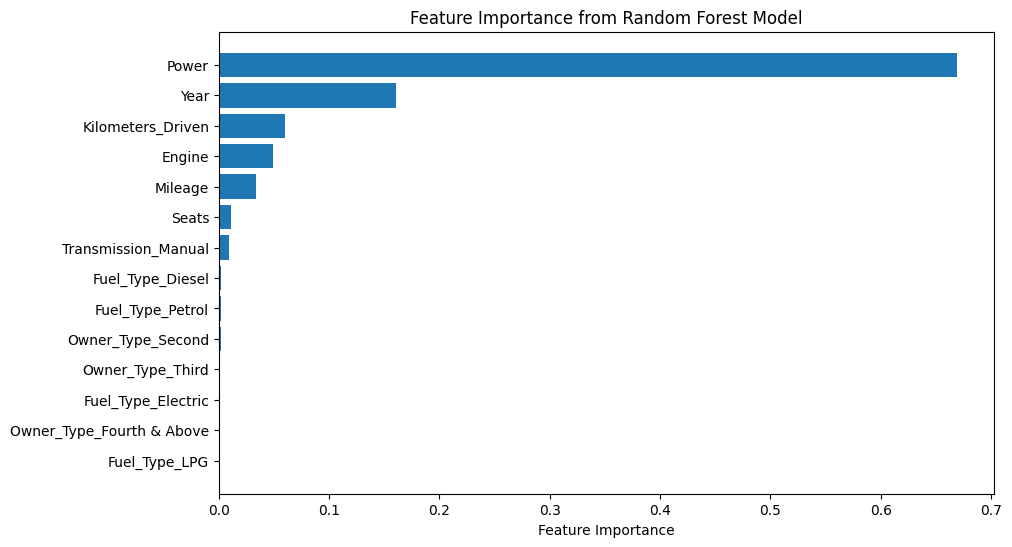

In [8]:
# Train a Random Forest model to determine feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
feature_importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


## Advanced Model Training

**Purpose:** To evaluate the performance of different machine learning models (Linear Regression, Random Forest, XGBoost) in predicting car prices.

**Benefit:** Helps in selecting the best-performing model for the task.

In [9]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)


                        MAE        MSE      RMSE        R2
Linear Regression  4.016023  64.977094  8.060837  0.471986
Random Forest      1.730052  17.505281  4.183931  0.857749
XGBoost            1.710602  19.442131  4.409323  0.842010


## Hyperparameter Tuning

**Purpose:** To optimize the performance of the Random Forest model by finding the best combination of hyperparameters.

**Benefit:** Enhances model accuracy and generalizability to new data by fine-tuning its parameters.

In [10]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 1.695921090017402
MSE: 15.156583787696036
RMSE: 3.893145744471434
R2: 0.8768353131114337


## Cross-Validation

In [11]:
# Function to evaluate model using cross-validation
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean(), rmse_scores.std()

# Evaluate Linear Regression
lr = LinearRegression()
lr_mean_rmse, lr_std_rmse = evaluate_model(lr, X_train, y_train)
print(f"Linear Regression: Mean RMSE = {lr_mean_rmse:.2f}, Std RMSE = {lr_std_rmse:.2f}")

# Evaluate Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mean_rmse, rf_std_rmse = evaluate_model(rf, X_train, y_train)
print(f"Random Forest: Mean RMSE = {rf_mean_rmse:.2f}, Std RMSE = {rf_std_rmse:.2f}")

# Evaluate XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb_mean_rmse, xgb_std_rmse = evaluate_model(xgb, X_train, y_train)
print(f"XGBoost: Mean RMSE = {xgb_mean_rmse:.2f}, Std RMSE = {xgb_std_rmse:.2f}")


Linear Regression: Mean RMSE = 6.14, Std RMSE = 0.76
Random Forest: Mean RMSE = 3.80, Std RMSE = 0.87
XGBoost: Mean RMSE = 3.91, Std RMSE = 0.87


## Making Predictions on New Data

In [12]:
# Function to predict prices of new data
def predict_new_data(model, new_data):
    # Ensure new data has the same preprocessing applied
    if 'Year' in new_data.columns:
        new_data['Age'] = 2024 - new_data['Year']
        new_data['Mileage_per_Year'] = new_data['Kilometers_Driven'] / new_data['Age']
        new_data = new_data.drop(columns=['Year'])

    # Ensure the correct dummy columns are added
    expected_columns = model.feature_names_in_
    new_data = pd.get_dummies(new_data)
    new_data = new_data.reindex(columns=expected_columns, fill_value=0)

    predictions = model.predict(new_data)
    return predictions

# Example usage with X_test
new_data = X_test.head(5).copy()  # Using a subset of X_test as example new data
predicted_prices = predict_new_data(best_rf_model, new_data)
print(predicted_prices)


[3.65235 6.8503  4.93735 2.52065 5.96765]


## Model Persistence

In [13]:
# Save the best model
joblib.dump(best_rf_model, 'best_rf_model.pkl')

# Load the model
loaded_model = joblib.load('best_rf_model.pkl')

# Verify the loaded model
y_pred = loaded_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Loaded Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")


Loaded Model - MAE: 1.695921090017402, MSE: 15.156583787696036, RMSE: 3.893145744471434, R2: 0.8768353131114337


## Prediction Visualization

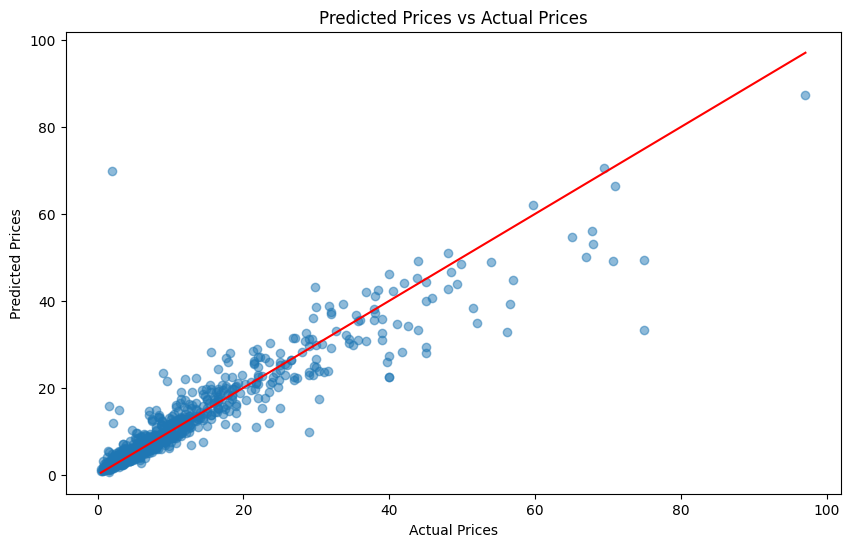

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.title('Predicted Prices vs Actual Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()


## Feature Engineering

In [15]:
# Check if 'Year' column is present before creating new features
if 'Year' in data.columns:
    data['Age'] = 2024 - data['Year']
    data['Mileage_per_Year'] = data['Kilometers_Driven'] / data['Age']
    data = data.drop(columns=['Year'])  # Drop 'Year' as it's now represented by 'Age'

# Convert categorical variables to dummy variables if they exist
categorical_columns = ['Fuel_Type', 'Transmission', 'Owner_Type']
for column in categorical_columns:
    if column in data.columns:
        data = pd.get_dummies(data, columns=[column], drop_first=True)

# Ensure all expected columns are in the data
expected_columns = loaded_model.feature_names_in_
for col in expected_columns:
    if col not in data.columns:
        data[col] = 0

# Re-split the data
X = data.drop(columns=['Name', 'Location', 'Price'])
y = data['Price']

# Ensure no NaN values in X
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model Comparison Visualization

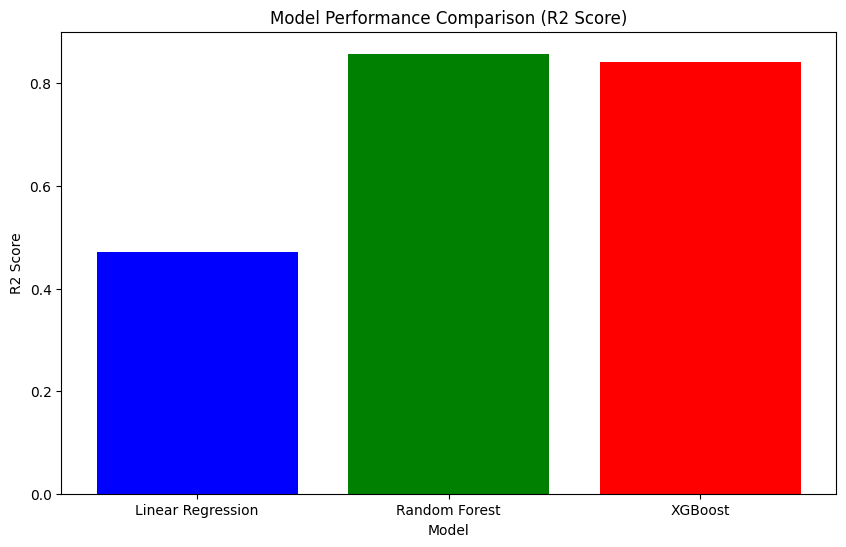

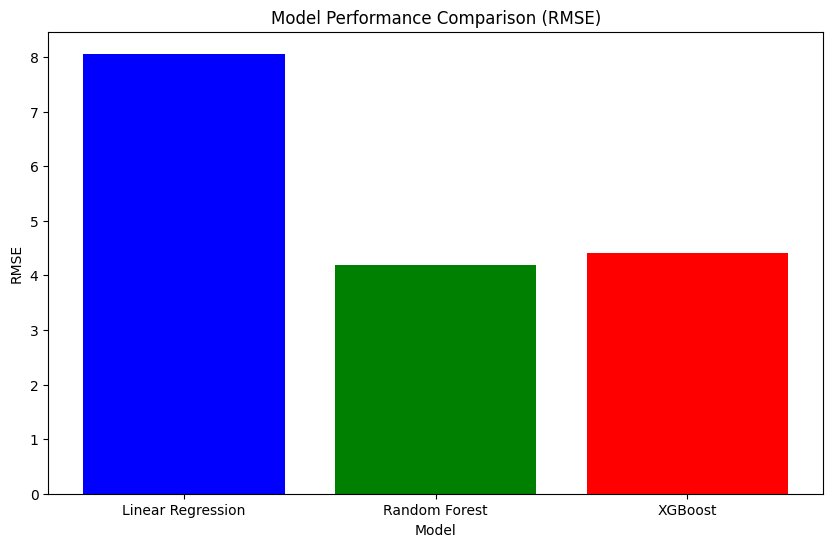

In [16]:
# Plotting model performance comparison
results_df = pd.DataFrame(results).T

plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['R2'], color=['blue', 'green', 'red'])
plt.title('Model Performance Comparison (R2 Score)')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['RMSE'], color=['blue', 'green', 'red'])
plt.title('Model Performance Comparison (RMSE)')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

## Residual Analysis

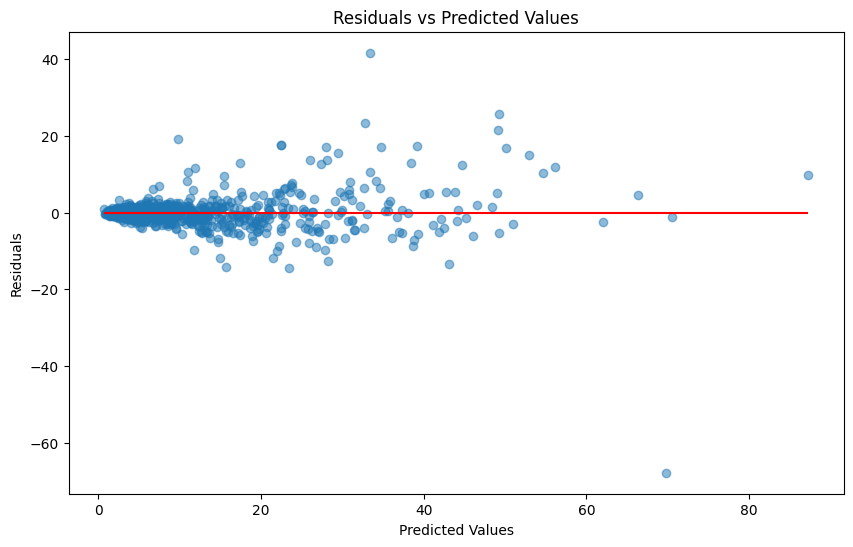

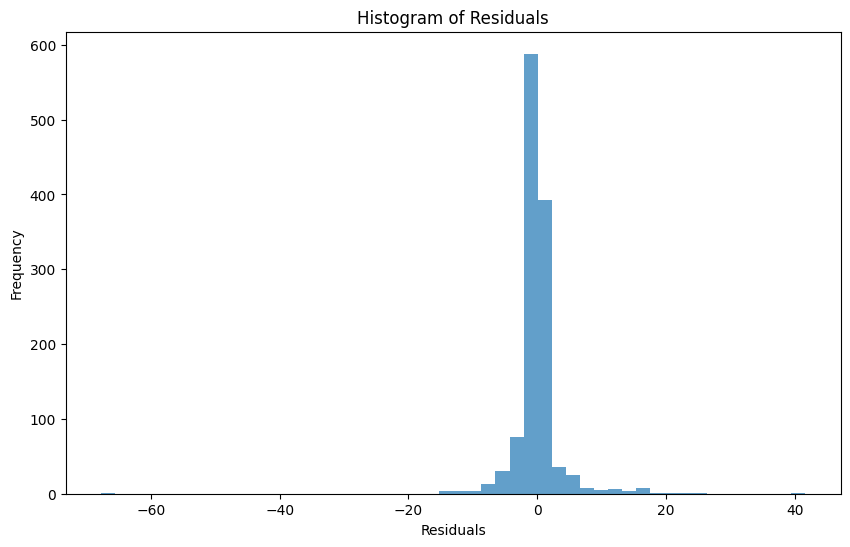

In [17]:
# Residual analysis for the best model (Random Forest in this case)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='red')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


## Advanced Feature Engineering

In [18]:
# Example: Creating polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the polynomial features data
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train a model on the polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train_poly)
y_pred_poly = model_poly.predict(X_test_poly)

# Evaluate the polynomial features model
mae_poly = mean_absolute_error(y_test_poly, y_pred_poly)
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)

print(f"Polynomial Features Model - MAE: {mae_poly}, MSE: {mse_poly}, RMSE: {rmse_poly}, R2: {r2_poly}")


Polynomial Features Model - MAE: 3.7237222261178045, MSE: 1991.0059428037832, RMSE: 44.62068962716492, R2: -15.179214721048897


## Time-Series Analysis

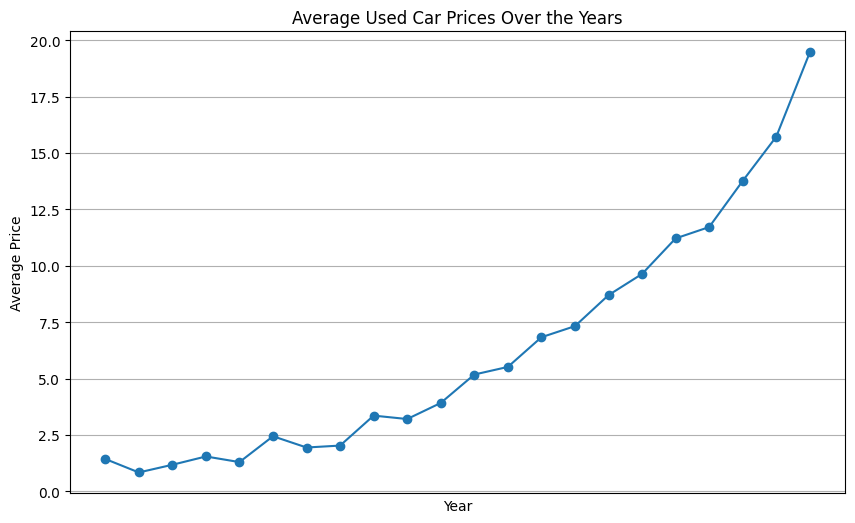

In [19]:
import matplotlib.dates as mdates

# Create a time series plot of average prices per year
data['Year'] = 2024 - data['Age']  # Recreate 'Year' column if necessary

avg_price_per_year = data.groupby('Year')['Price'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_price_per_year.index, avg_price_per_year.values, marker='o')
plt.title('Average Used Car Prices Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.show()


## Clustering Analysis

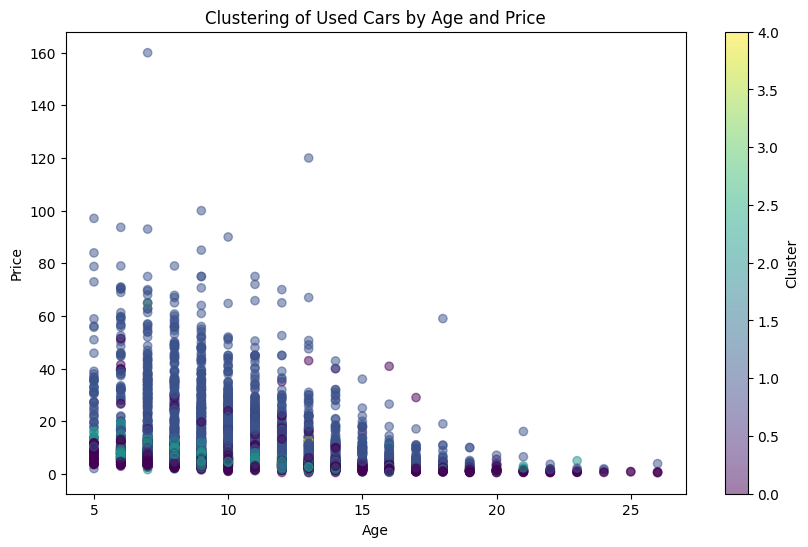

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataset
data['Cluster'] = clusters

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['Age'], data['Price'], c=data['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustering of Used Cars by Age and Price')
plt.xlabel('Age')
plt.ylabel('Price')
plt.colorbar(label='Cluster')
plt.show()


## Feature Selection

In [21]:
from sklearn.feature_selection import RFE

# Use RFE with a Random Forest model
selector = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=10)
selector = selector.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)

# Train a model using only the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

model_rf_selected = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_selected.fit(X_train_selected, y_train)

# Evaluate the model
y_pred_selected = model_rf_selected.predict(X_test_selected)
mae_selected = mean_absolute_error(y_test, y_pred_selected)
mse_selected = mean_squared_error(y_test, y_pred_selected)
rmse_selected = np.sqrt(mse_selected)
r2_selected = r2_score(y_test, y_pred_selected)

print(f"Selected Features Model - MAE: {mae_selected}, MSE: {mse_selected}, RMSE: {rmse_selected}, R2: {r2_selected}")


Selected Features: Index(['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Transmission_Manual', 'Age',
       'Mileage_per_Year'],
      dtype='object')
Selected Features Model - MAE: 1.7231158662263357, MSE: 17.371580266116432, RMSE: 4.167922775930047, R2: 0.8588359174992517


## Model Explanation with SHAP

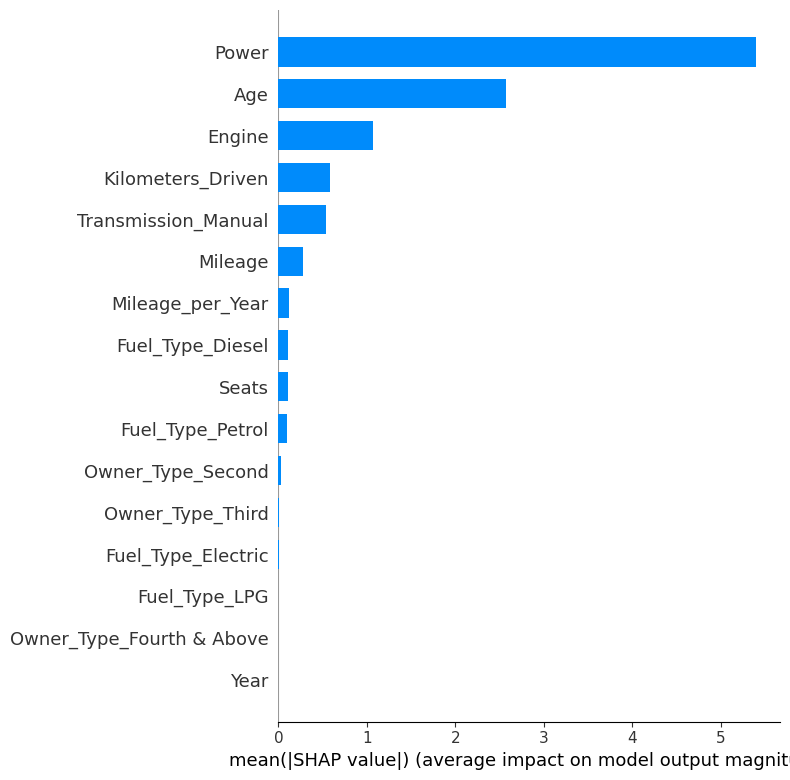

In [22]:
import shap

# Fit the model on the entire dataset for SHAP values
model_shap = RandomForestRegressor(n_estimators=100, random_state=42)
model_shap.fit(X, y)

# Calculate SHAP values
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X, plot_type="bar")

# Detailed SHAP plot for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


## Scenario Analysis

In [24]:
# Ensure the new data has the same features as the training data
def preprocess_new_data(new_data):
    # Add new features
    if 'Year' in new_data.columns:
        new_data['Age'] = 2024 - new_data['Year']
        new_data['Mileage_per_Year'] = new_data['Kilometers_Driven'] / new_data['Age']
        new_data = new_data.drop(columns=['Year'])

    # Ensure all expected dummy columns are present
    expected_columns = loaded_model.feature_names_in_
    new_data = pd.get_dummies(new_data)
    new_data = new_data.reindex(columns=expected_columns, fill_value=0)

    return new_data

# Example: Simulating different scenarios for a specific car
car_example = X_test.head(1).copy()

# Scenario 1: Increase mileage
car_example_scenario_1 = car_example.copy()
car_example_scenario_1['Kilometers_Driven'] += 20000
car_example_scenario_1 = preprocess_new_data(car_example_scenario_1)
predicted_price_scenario_1 = loaded_model.predict(car_example_scenario_1)

# Scenario 2: Change fuel type to Diesel
car_example_scenario_2 = car_example.copy()
car_example_scenario_2['Fuel_Type_Diesel'] = 1
car_example_scenario_2['Fuel_Type_Petrol'] = 0
car_example_scenario_2 = preprocess_new_data(car_example_scenario_2)
predicted_price_scenario_2 = loaded_model.predict(car_example_scenario_2)

# Original price
car_example = preprocess_new_data(car_example)
predicted_price_original = loaded_model.predict(car_example)

print(f"Original Price: {predicted_price_original}")
print(f"Scenario 1 (Increased mileage): {predicted_price_scenario_1}")
print(f"Scenario 2 (Changed to Diesel): {predicted_price_scenario_2}")


Original Price: [3.65235]
Scenario 1 (Increased mileage): [3.70745]
Scenario 2 (Changed to Diesel): [3.65235]


## Hyperparameter Tuning for XGBoost

In [25]:
# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

# Initialize the model
xgb_model = XGBRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_
print(f"Best parameters for XGBoost: {best_params_xgb}")

# Train the model with the best parameters
best_xgb_model = XGBRegressor(**best_params_xgb, random_state=42)
best_xgb_model.fit(X_train, y_train)
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Model - MAE: {mae_xgb}, MSE: {mse_xgb}, RMSE: {rmse_xgb}, R2: {r2_xgb}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.6}
XGBoost Model - MAE: 1.6661080743030854, MSE: 16.98536558807419, RMSE: 4.121330560398448, R2: 0.8619743562503016


## Cross-Validation with Polynomial Features

In [26]:
# Evaluate Linear Regression with polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)

lr_poly = LinearRegression()
lr_mean_rmse_poly, lr_std_rmse_poly = evaluate_model(lr_poly, X_train_poly, y_train_poly)
print(f"Linear Regression with Polynomial Features: Mean RMSE = {lr_mean_rmse_poly:.2f}, Std RMSE = {lr_std_rmse_poly:.2f}")


Linear Regression with Polynomial Features: Mean RMSE = 4.50, Std RMSE = 0.70


## Save and Load Best XGBoost Model

In [27]:
# Save the best XGBoost model
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

# Load the best XGBoost model
loaded_xgb_model = joblib.load('best_xgb_model.pkl')

# Verify the loaded model
y_pred_loaded_xgb = loaded_xgb_model.predict(X_test)
mae_loaded_xgb = mean_absolute_error(y_test, y_pred_loaded_xgb)
mse_loaded_xgb = mean_squared_error(y_test, y_pred_loaded_xgb)
rmse_loaded_xgb = np.sqrt(mse_loaded_xgb)
r2_loaded_xgb = r2_score(y_test, y_pred_loaded_xgb)

print(f"Loaded XGBoost Model - MAE: {mae_loaded_xgb}, MSE: {mse_loaded_xgb}, RMSE: {rmse_loaded_xgb}, R2: {r2_loaded_xgb}")


Loaded XGBoost Model - MAE: 1.6661080743030854, MSE: 16.98536558807419, RMSE: 4.121330560398448, R2: 0.8619743562503016


## Scenario Analysis for XGBoost

In [29]:
# Ensure the new data has the same features as the training data
def preprocess_new_data(new_data):
    # Add new features
    if 'Year' in new_data.columns:
        new_data['Age'] = 2024 - new_data['Year']
        new_data['Mileage_per_Year'] = new_data['Kilometers_Driven'] / new_data['Age']
        new_data = new_data.drop(columns=['Year'])

    # Ensure all expected dummy columns are present
    expected_columns = loaded_xgb_model.feature_names_in_
    new_data = pd.get_dummies(new_data)
    new_data = new_data.reindex(columns=expected_columns, fill_value=0)

    return new_data

# Example: Simulating different scenarios for a specific car
car_example = X_test.head(1).copy()

# Scenario 1: Increase mileage
car_example_scenario_1 = car_example.copy()
car_example_scenario_1['Kilometers_Driven'] += 20000
car_example_scenario_1 = preprocess_new_data(car_example_scenario_1)
predicted_price_scenario_1 = loaded_xgb_model.predict(car_example_scenario_1)

# Scenario 2: Change fuel type to Diesel
car_example_scenario_2 = car_example.copy()
car_example_scenario_2['Fuel_Type_Diesel'] = 1
car_example_scenario_2['Fuel_Type_Petrol'] = 0
car_example_scenario_2 = preprocess_new_data(car_example_scenario_2)
predicted_price_scenario_2 = loaded_xgb_model.predict(car_example_scenario_2)

# Original price
car_example = preprocess_new_data(car_example)
predicted_price_original = loaded_xgb_model.predict(car_example)

print(f"Original Price: {predicted_price_original}")
print(f"Scenario 1 (Increased mileage): {predicted_price_scenario_1}")
print(f"Scenario 2 (Changed to Diesel): {predicted_price_scenario_2}")


Original Price: [2.4084067]
Scenario 1 (Increased mileage): [2.4077427]
Scenario 2 (Changed to Diesel): [2.4084067]


## Residual Analysis

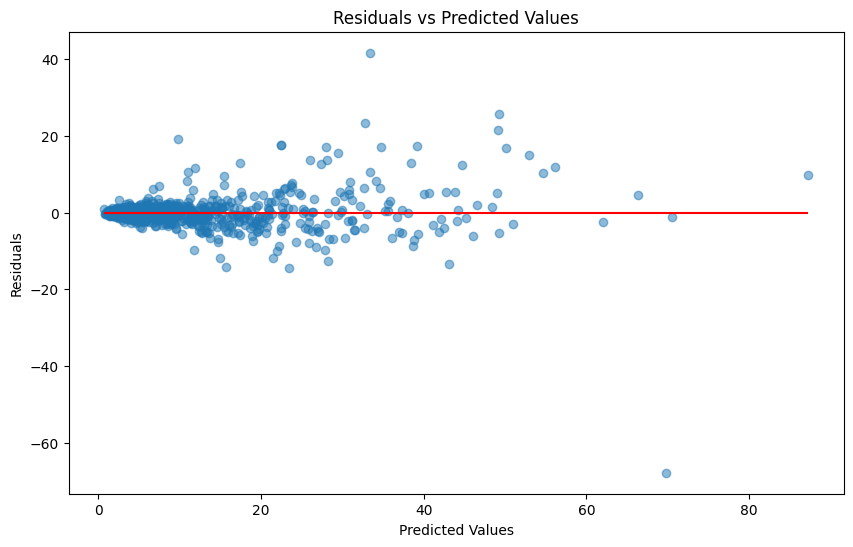

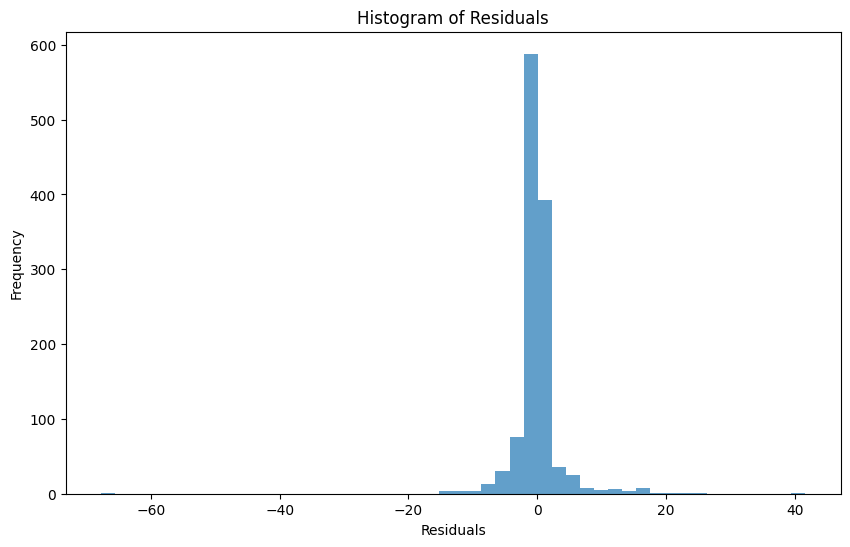

In [30]:
# Residual analysis for the best model (Random Forest in this case)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='red')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
